# README

This notebook is a good starting point for learning how we run our measurements.
We will setup a 'dry run', i.e., perform a dummy measurement in which we will simply directly measure the output of the OPX.

We assume that one of the DACs of the OPX is directly connected to one of the ADCs.

To use this notebook, you have to do the following things first:
- make sure you have a valid configuration for the OPX. You'll probably have to read the QUA code a bit and make sure it's all compatible. This notebook comes with one that was used to test this notebook. It makes use of the ParameterManager (see next point). Make sure the config corresponds correctly with your hardware setup.
- have instrumentserver started, and a ParameterManager instrument instantiated. This notebook comes with pre-saved parameters that were used during testing. They are used in the OPX config.

Once this is done, you should be able to execute the below (some config needed).

# Initialization

In [1]:
%matplotlib inline

## setup for measurements

This should be the only place where specific settings of your setup need to be declared.

In [2]:
### basic measurement setup

from instrumentserver.client import Client
from labcore.setup import setup_opx_measurements
from labcore.setup.setup_opx_measurements import *

# get the client to the instrumentserver, with default settings.
isrvr = Client()

# fill in the name of your parameter manager instrument.
params = find_or_create_remote_instrument(isrvr, 'simple_demo_params')  

# make sure you specify the correct IP and port for your OPX system.
import qmcfg_simple_demo as qmcfg
qm_config = qmcfg.QMConfig(params, '128.174.248.249', '80')

# these need to be specified so all measurement code is configured correctly
setup_opx_measurements.options.instrument_clients = {'instruments': isrvr}
setup_opx_measurements.options.parameters = params
setup_opx_measurements.options.qm_config = qm_config

[2022-12-01 18:14:50.673] [root: INFO] Logging set up for <RootLogger root (INFO)>.
[2022-12-01 18:14:50.674] [instrumentserver.client.core: INFO] Connecting to tcp://localhost:5555


## setup for analysis

we import everything we need below to load data and analyze it.

In [3]:
### basic plotting and analysis setup
import numpy as np
from matplotlib import pyplot as plt

from labcore.analysis.data import get_data, data_info, DatasetAnalysis
from labcore.plotting.basics import setup_plotting, format_ax, add_legend, ppcolormesh

from labcore.setup.setup_notebook_analysis import *

# Measurements

## Raw data example: directly measure the DAC output with the ADC

### Run the measurement

Here, we define the entire measurment in the notebook.
For measurements that we use regularly in some standard from, the QUA code is often placed into some version controlled module.

Just for illustration and as a basic tutorial, we leave it here in this case.

This measurement is very basic -- we play a readout pulse and directly read it in again.
We include the raw data. See QM docs for reference.

We make use of our own sweep framework that enables us to hide a lot of technical overhead in the background here.
It also automatically sets up correctly labeled data.

In [20]:
from qm.qua import *
from labcore.sweep import independent
from labcore.opx.sweep import \
    RecordOPXdata, ComplexOPXData, TimedOPXData

@RecordOPXdata(
    independent('repetition'),
    TimedOPXData('raw_signal', depends_on=['repetition']),
    TimedOPXData('I', depends_on=['repetition']),
    TimedOPXData('Q', depends_on=['repetition']),
)
def measure_opx_output(n_reps=10, rep_delay_ns=0):
    # this is in units of 4 ns.
    # for the data to look 'good', make sure that you have a chunksize that has an even number of
    # IF periods contained in it.
    _chunksize = int(20 // 4)
    _n_chunks = params.readout.short.len() // (4 * _chunksize)
    
    with program() as raw_measurement:
        rep_stream = declare_stream()
        raw_stream = declare_stream(adc_trace=True)
        i_stream = declare_stream()
        q_stream = declare_stream()

        rep = declare(int)
        I = declare(fixed, size=_n_chunks)
        Q = declare(fixed, size=_n_chunks)
        j = declare(int)
    
        with for_(rep, 0, rep < n_reps, rep + 1):
            measure('readout_short', 'readout', raw_stream, 
                    demod.sliced("readout_short_sliced_cos", I, _chunksize),
                    demod.sliced("readout_short_sliced_sin", Q, _chunksize),)
            
            save(rep, rep_stream)
            
            with for_(j, 0, j < _n_chunks, j + 1):
                save(I[j], i_stream)
                save(Q[j], q_stream)
                
            if rep_delay_ns > 20:
                wait(int(rep_delay_ns)//4)

        with stream_processing():
            raw_stream.input2().save_all('raw_signal')
            rep_stream.save_all('repetition')
            i_stream.buffer(_n_chunks).save_all('I')
            q_stream.buffer(_n_chunks).save_all('Q')
            
    return raw_measurement


measurement = measure_opx_output(n_reps=100,
                                 rep_delay_ns=1e6, 
                                 collector_options=dict(batchsize=10)
                                 )
data_loc, _ = run_measurement(sweep=measurement, name='test')

[2022-12-02 17:16:35.522] [plottr.data.datadict_storage: INFO] Data location: /home/pfafflab/Documents/github/measurement-tools/examples/opx_demos/data/2022-12-02/2022-12-02T171635_5da67cea-test/data.ddh5
[2022-12-02 17:16:35.532] [qm: INFO] Performing health check
[2022-12-02 17:16:35.534] [qm: INFO] Health check passed
[2022-12-02 17:16:35.540] [root: INFO] Integration weights file not found, using flat weights.
[2022-12-02 17:16:35.547] [qm: INFO] Performing health check
[2022-12-02 17:16:35.550] [qm: INFO] Health check passed
chunksize: 5
n_chunks: 50
[2022-12-02 17:16:35.605] [qm: INFO] Flags: 
[2022-12-02 17:16:35.606] [qm: INFO] Sending program to QOP
[2022-12-02 17:16:35.857] [qm: INFO] Executing program
[2022-12-02 17:16:36.216] [labcore.ddh5: INFO] The measurement has finished successfully and all of the data has been saved.


### Analyse the data

In [21]:
### get some basic information about the data we just wrote
data_info(data_loc)

I: (100, 50)
  ⌙ I_time_points: (100, 50)
  ⌙ repetition: (100,)
Q: (100, 50)
  ⌙ Q_time_points: (100, 50)
  ⌙ repetition: (100,)
raw_signal: (100, 1000)
  ⌙ raw_signal_time_points: (100, 1000)
  ⌙ repetition: (100,)


/home/pfafflab/Documents/github/measurement-tools/qcuiuc_measurement/analysis/plotting.py:264: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(_x, _y, z, cmap=cmap, **kw)


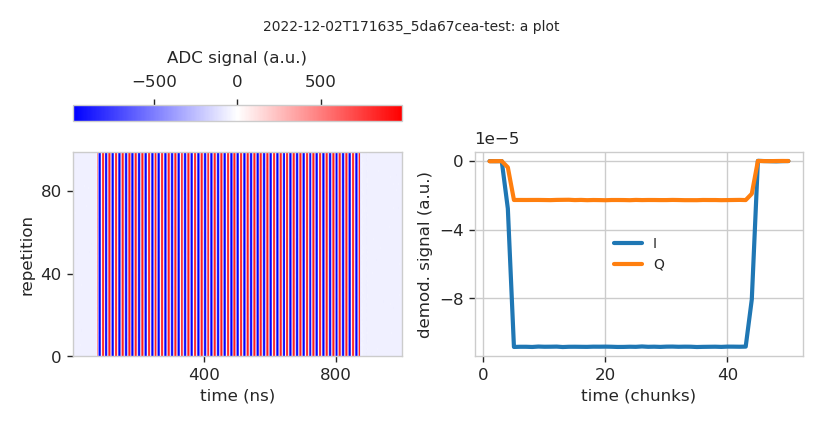

In [22]:
### using the DatasetAnalysis context helps us to load data easily, and automatically save plots in the right folder.

with DatasetAnalysis(data_loc) as analysis:
    i_data = analysis.get_data('I', avg_over=None)
    q_data = analysis.get_data('Q', avg_over=None)
    raw_data = analysis.get_data('raw_signal', avg_over=None)
    
    fig = analysis.make_figure('a plot', figsize=(4,2))
    
    # first subfig: plot the raw voltage as a colormap. We set the limits such that 0 is the middle.
    ax = fig.add_subplot(121)
    im = ppcolormesh(ax,
                     raw_data.data_vals('raw_signal_time_points'),
                     raw_data.data_vals('repetition'),
                     raw_data.data_vals('raw_signal'),
                     make_grid=False,
                     cmap='bwr', 
                     vmin=-np.abs(raw_data.data_vals('raw_signal')).max(),
                     vmax=np.abs(raw_data.data_vals('raw_signal')).max()
                     )
    format_ax(ax, xlabel='time (ns)', ylabel='repetition')
    cb = fig.colorbar(im, ax=ax, location='top')
    cb.set_label('ADC signal (a.u.)')
    
    # second subfig: plot one example trace of demodulated I and Q.
    ax = fig.add_subplot(122)
    ax.plot(i_data.data_vals('I_time_points')[:,0], i_data.data_vals('I')[:,0], '-',
            label='I')
    ax.plot(q_data.data_vals('Q_time_points')[:,0], q_data.data_vals('Q')[:,0], '-',
            label='Q')
    format_ax(ax, xlabel='time (chunks)', ylabel='demod. signal (a.u.)')
    ax.legend(loc='best')
    
    # this command saves the figures associated with the analysis in the data folder.
    analysis.save()